In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [5]:
!pip install keras_cv -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 42.0 MB/s eta 0:00:00


In [2]:
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0


In [3]:
!pip install segmentation_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.6 MB/s eta 0:00:00


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import keras
from tensorflow.keras import ops
import keras_cv
import numpy as np
import segmentation_models as sm
from keras_cv.datasets.pascal_voc.segmentation import load as load_voc
from tensorflow.keras import backend as K

Segmentation Models: using `tf.keras` framework.


In [7]:
!mkdir -p ~/.keras/datasets
!wget -qO- https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/semantic_contours/benchmark.tgz \
  | tar -xz -C ~/.keras/datasets


from keras_cv.datasets import pascal_voc
import os

BASE_DIR = f"{os.path.expanduser('~')}/.keras/datasets"
train_ds = pascal_voc.segmentation.load(split="sbd_train", data_dir=BASE_DIR)
eval_ds  = pascal_voc.segmentation.load(split="sbd_eval",  data_dir=BASE_DIR)

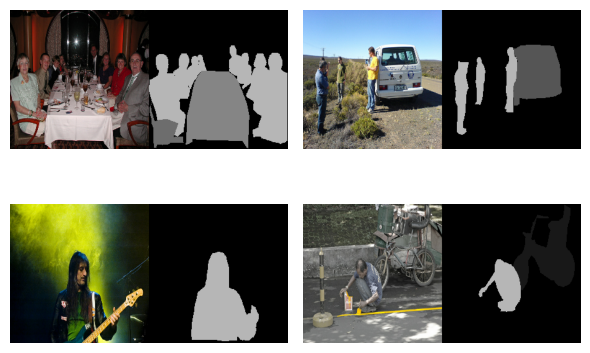

In [8]:
def preprocess_tfds_inputs(inputs):
    def unpackage_tfds_inputs(tfds_inputs):
        return {
            "images": tfds_inputs["image"],
            "segmentation_masks": tfds_inputs["class_segmentation"],
        }

    outputs = inputs.map(unpackage_tfds_inputs)
    outputs = outputs.map(keras_cv.layers.Resizing(height=224, width=224))
    outputs = outputs.batch(32, drop_remainder=True)
    return outputs


train_ds = preprocess_tfds_inputs(train_ds)
batch = train_ds.take(1).get_single_element()
keras_cv.visualization.plot_segmentation_mask_gallery(
    batch["images"],
    value_range=(0, 255),
    num_classes=21,
    y_true=batch["segmentation_masks"],
    scale=3,
    rows=2,
    cols=2,
)

In [9]:
eval_ds = preprocess_tfds_inputs(eval_ds)

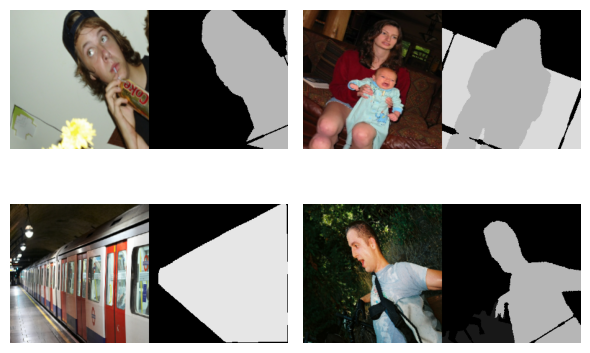

In [10]:
train_ds = train_ds.map(keras_cv.layers.RandomFlip())
train_ds = train_ds.map(keras_cv.layers.RandomRotation(factor=.1,segmentation_classes=21))

batch = train_ds.take(1).get_single_element()

keras_cv.visualization.plot_segmentation_mask_gallery(
    batch["images"],
    value_range=(0, 255),
    num_classes=21,
    y_true=batch["segmentation_masks"],
    scale=3,
    rows=2,
    cols=2,
)

In [19]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.models import Model
def unet_model(input_size=(224, 224, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    p5 = MaxPooling2D((2, 2))(c5)

    # Bottleneck
    c6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p5)
    c6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c6)

    # Decoder
    u8 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c6)
    u8 = concatenate([u8, c5])
    c8 = Conv2D(512, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(512, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c4])
    c9 = Conv2D(256, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(256, (3, 3), activation='relu', padding='same')(c9)

    u10 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = concatenate([u10, c3])
    c10 = Conv2D(128, (3, 3), activation='relu', padding='same')(u10)
    c10 = Conv2D(128, (3, 3), activation='relu', padding='same')(c10)

    u11 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c10)
    u11 = concatenate([u11, c2])
    c11 = Conv2D(64, (3, 3), activation='relu', padding='same')(u11)
    c11 = Conv2D(64, (3, 3), activation='relu', padding='same')(c11)

    u12 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c11)
    u12 = concatenate([u12, c1])
    c12 = Conv2D(32, (3, 3), activation='relu', padding='same')(u12)
    c12 = Conv2D(32, (3, 3), activation='relu', padding='same')(c12)

    outputs = Conv2D(21, (1, 1), activation='softmax', padding='valid')(c12)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model
model = unet_model()


In [15]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [16]:
def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [22]:
metrics=['accuracy', jaccard_coef]
#compile the model
####################
model.compile(optimizer='adam',
              loss=total_loss,
              metrics=['accuracy', jaccard_coef])
####################

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 224, 224,  │      9,248 │ conv2d_37[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 112, 112,  │          0 │ conv2d_38[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_15… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 112, 112,  │     36,928 │ conv2d_39[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 56, 56,    │          0 │ conv2d_40[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_16… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 56, 56,    │    147,584 │ conv2d_41[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 28, 28,    │          0 │ conv2d_42[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 28, 28,    │    295,168 │ max_pooling2d_17… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 28, 28,    │    590,080 │ conv2d_43[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 14, 14,    │          0 │ conv2d_44[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 14, 14,    │  1,180,160 │ max_pooling2d_18… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 14, 14,    │  2,359,808 │ conv2d_45[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 7, 7, 512) │          0 │ conv2d_46[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 7, 7,      │  4,719,616 │ max_pooling2d_19

 Total params: 31,094,497 (118.62 MB)

 Trainable params: 31,094,497 (118.62 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
def dict_to_tuple(x):


    return x["images"], tf.one_hot(
        tf.cast(tf.squeeze(x["segmentation_masks"], axis=-1), "int32"), 21
    )


train_ds = train_ds.map(dict_to_tuple)

eval_ds = eval_ds.map(dict_to_tuple)



In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath = "best_custom.weights.h5", monitor="val_loss", mode = "min", save_best_only = True, save_weights_only = True, verbose =1)
model.fit(train_ds, validation_data=eval_ds, epochs=10, callbacks=[checkpoint])

Epoch 1/10
    169/Unknown 6917s 41s/step - accuracy: 0.6253 - jaccard_coef: 0.3076 - loss: 0.9762

In [ ]:
activation='softmax'

LR = 0.001
optim = keras.optimizers.Adam(LR)


dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


In [ ]:
BACKBONE1 = 'mobilenetv2'

n_classes=21
# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)
model1.compile(optim, total_loss, metrics=metrics)
print(model1.summary())

In [ ]:
flag = True
for l in model1.layers:
  if  l.name=='decoder_stage0_upsampling':
    flag = False
  if flag:
    l.trainable = False

In [ ]:
model1.summary()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath = "freezed.weights.h5", monitor="val_loss", mode = "min", save_best_only = True, save_weights_only = True, verbose =1)
model1.fit(train_ds, validation_data=eval_ds, epochs=10, batch_size=32, callbacks=[checkpoint] )

In [ ]:
#let all the layers be trained
####################
for l in model1.layers:
    l.trainable = True
####################

In [ ]:
LR = 0.000005
optim = keras.optimizers.Adam(LR)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath = "full.weights.h5", monitor="val_loss", mode = "min", save_best_only = True, save_weights_only = True, verbose =1)

In [ ]:
model1.fit(train_ds, validation_data=eval_ds, epochs=5, batch_size=32, callbacks=[checkpoint] )